# General Task Performance 

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from functools import partial
from pathlib import Path
import logging

from mono_multi.setup import LLM_MODELS, PAPER_TASKS, BASELINES, FIGURES_ROOT_DIR

from mono_multi.utils import (
    key_to_model,
    model_to_key,
    prettify_model_name,
    get_size,
    is_instruction_tuned,
    load_model_outputs_same_prompt,
    get_metric,
    load_results_overview,
    add_evals_to_df,
    load_data_if_needed,
    filter_results_all_tasks,
    sort_by_size_and_family
)
from mono_multi.baseline.utils import load_baselines

from mono_multi.plotting import (
    plot_accuracies,
    plot_label_dist,
    plot_general_performance_task
)

/Users/mgorecki/opt/miniconda3/envs/monoc-py311/lib/python3.11/site-packages/xport/__about__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [ ]:
plot_config_file = "./results/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

FIGURES_PAPER_DIR = FIGURES_ROOT_DIR / "same-prompt"
TASKS = PAPER_TASKS
print("tasks", PAPER_TASKS)

tasks ('ACSIncome', 'ACSEmployment', 'BRFSS_Blood_Pressure', 'SIPP', 'ACSTravelTime', 'ACSPublicCoverage', 'ACSMobility')


In [33]:
select_by='accuracy' #'balanced_accuracy' #
fit_threshold_for= 'balanced_accuracy' #'accuracy' #

## Load Task Data

In [34]:
try:
    data_all
except NameError:
    print("'data_all' not yet defined")
    data_all = load_data_if_needed(data=None, tasks=TASKS)
else:
    print("Already defined, update if needed.")
    data_all = load_data_if_needed(data=data_all, tasks=TASKS)

Already defined, update if needed.


## Load Baselines

In [35]:
baseline_scores, baseline_evals = load_baselines(baselines=BASELINES, tasks=TASKS)

baseline_predictions = {
    task: baseline_scores[task].map(lambda x: int(x >= 0.5)) for task in TASKS
}
baseline_predictions["ACSIncome"].head()

Loading baselines for ACSIncome.
- Constant: Load predictions from 'results/baselines/model-Constant/Constant_task-ACSIncome/Constant_bench-211220205'.
- LogisticRegression: Load predictions from 'results/baselines/model-LogisticRegression/LogisticRegression_task-ACSIncome/LogisticRegression_bench-790429520'.
- GBM: Load predictions from 'results/baselines/model-GBM/GBM_task-ACSIncome/GBM_bench-996001762'.
- XGBoost: Load predictions from 'results/baselines/model-XGBoost/XGBoost_task-ACSIncome/XGBoost_bench-3794332052'.
- NN: Load predictions from 'results/baselines/model-NN/NN_task-ACSIncome/NN_bench-276142988'.
Loading baselines for ACSEmployment.
- Constant: Load predictions from 'results/baselines/model-Constant/Constant_task-ACSEmployment/Constant_bench-1469218015'.
- LogisticRegression: Load predictions from 'results/baselines/model-LogisticRegression/LogisticRegression_task-ACSEmployment/LogisticRegression_bench-2439278790'.
- GBM: Load predictions from 'results/baselines/model-

,Constant,LogisticRegression,GBM,XGBoost,NN
238351,0,0,0,0,0
2995677,0,0,0,0,0
2360043,0,0,1,1,1
1924596,0,0,0,0,0
2803585,0,0,0,0,0


In [36]:
print(f"{'baseline':20} & " + " & ".join(TASKS) + "\\\\")
for baseline in BASELINES:
    row = f"{baseline:20} & "
    for task in TASKS:
        row += f"\t{baseline_evals[task][baseline]['balanced_accuracy']:.4f} & "
    print(row[:-2]+"\\\\")

baseline             & ACSIncome & ACSEmployment & BRFSS_Blood_Pressure & SIPP & ACSTravelTime & ACSPublicCoverage & ACSMobility\\
Constant             & 	0.5000 & 	0.5000 & 	0.5000 & 	0.5000 & 	0.5000 & 	0.5000 & 	0.5000 \\
LogisticRegression   & 	0.7116 & 	0.7857 & 	0.6423 & 	0.6340 & 	0.5235 & 	0.5859 & 	0.5164 \\
GBM                  & 	0.7952 & 	0.8329 & 	0.6607 & 	0.8184 & 	0.6663 & 	0.7114 & 	0.5980 \\
XGBoost              & 	0.7995 & 	0.8336 & 	0.6612 & 	0.8168 & 	0.6859 & 	0.7193 & 	0.6055 \\
NN                   & 	0.7740 & 	0.8299 & 	0.6519 & 	0.6830 & 	0.6076 & 	0.6809 & 	0.5516 \\


## Load predictions

In [37]:
num_shots = 10
threshold_fitted = True

df = load_results_overview(
    num_shots=num_shots, threshold_fitted=threshold_fitted, same_prompt=True
)
df = df[df["task"].isin(TASKS)]
df = df[df["correct_order_bias"]==0]
if threshold_fitted and ("threshold_obj" in df.columns):
    df = df[df["threshold_obj"]==fit_threshold_for]

df['predictions_path'] = '/Volumes/mgorecki/monoculture/' + df['predictions_path']

df.shape

(340, 19)

In [38]:
try:
    assert set(TASKS).issubset(
        set(df["task"].unique())
    ), f"Results for all tasks to be analysed have to be available, available are: {list(df['task'].unique())} "
except AssertionError:
    TASKS = list(df["task"].unique())
    logging.warning(f"Reduced TASKS to available tasks: {TASKS}")

In [39]:
predictions_all = load_model_outputs_same_prompt(
    df, tasks=TASKS, return_risk_scores=False
)

df = add_evals_to_df(df, metrics=["fpr", "fnr", "n_samples", "num_pred_negatives"])

ACSIncome
ACSEmployment
BRFSS_Blood_Pressure
SIPP
ACSTravelTime
ACSPublicCoverage
ACSMobility


## Restrict analysis to models based on performance?

In [40]:
restrict_to_better_const = False
restrict_to_positive_label = False
restrict_to_negative_label = False
restrict_to_top_eps = False
eps = 0.05
restrict_to_topk = False
topk = 10

predictions, data = filter_results_all_tasks(
    predictions=predictions_all.copy(),
    df=df,
    data={t: val for t, val in data_all.items() if t in TASKS},
    tasks=TASKS,
    restrict_to_better_const=restrict_to_better_const,
    restrict_to_positive_label=restrict_to_positive_label,
    restrict_to_negative_label=restrict_to_negative_label,
    restrict_to_top_eps=restrict_to_top_eps,
    restrict_to_topk=restrict_to_topk,
    eps=eps,
    topk=topk,
    acc=select_by
)

ACSIncome
- before: (166450, 50)
- after: (166450, 50)
ACSEmployment
- before: (323611, 49)
- after: (323611, 49)
BRFSS_Blood_Pressure
- before: (84676, 48)
- after: (84676, 48)
SIPP
- before: (3972, 47)
- after: (3972, 47)
ACSTravelTime
- before: (146665, 48)
- after: (146665, 48)
ACSPublicCoverage
- before: (113829, 49)
- after: (113829, 49)
ACSMobility
- before: (62094, 49)
- after: (62094, 49)


In [41]:
{task: predictions[task].shape[1] for task in TASKS}

{'ACSIncome': 50,
 'ACSEmployment': 49,
 'BRFSS_Blood_Pressure': 48,
 'SIPP': 47,
 'ACSTravelTime': 48,
 'ACSPublicCoverage': 49,
 'ACSMobility': 49}

In [42]:
{task: [mod for mod in LLM_MODELS if model_to_key(mod) not in predictions[task].columns] for task in TASKS}

{'ACSIncome': [],
 'ACSEmployment': ['gpt-3.5-turbo-0125'],
 'BRFSS_Blood_Pressure': ['gpt-4.1', 'gpt-3.5-turbo-0125'],
 'SIPP': ['google/gemma-7b', 'gpt-4.1', 'gpt-3.5-turbo-0125'],
 'ACSTravelTime': ['gpt-4.1', 'gpt-3.5-turbo-0125'],
 'ACSPublicCoverage': ['gpt-3.5-turbo-0125'],
 'ACSMobility': ['gpt-4.1']}

## Plot General Performance

In [ ]:
from mono_multi.utils import get_top_models_by_eps

ACSIncome
ACSEmployment
BRFSS_Blood_Pressure
SIPP
ACSTravelTime
ACSPublicCoverage
ACSMobility
performance-accuracy-10-shot_tresh_fitted-balanced-accuracy


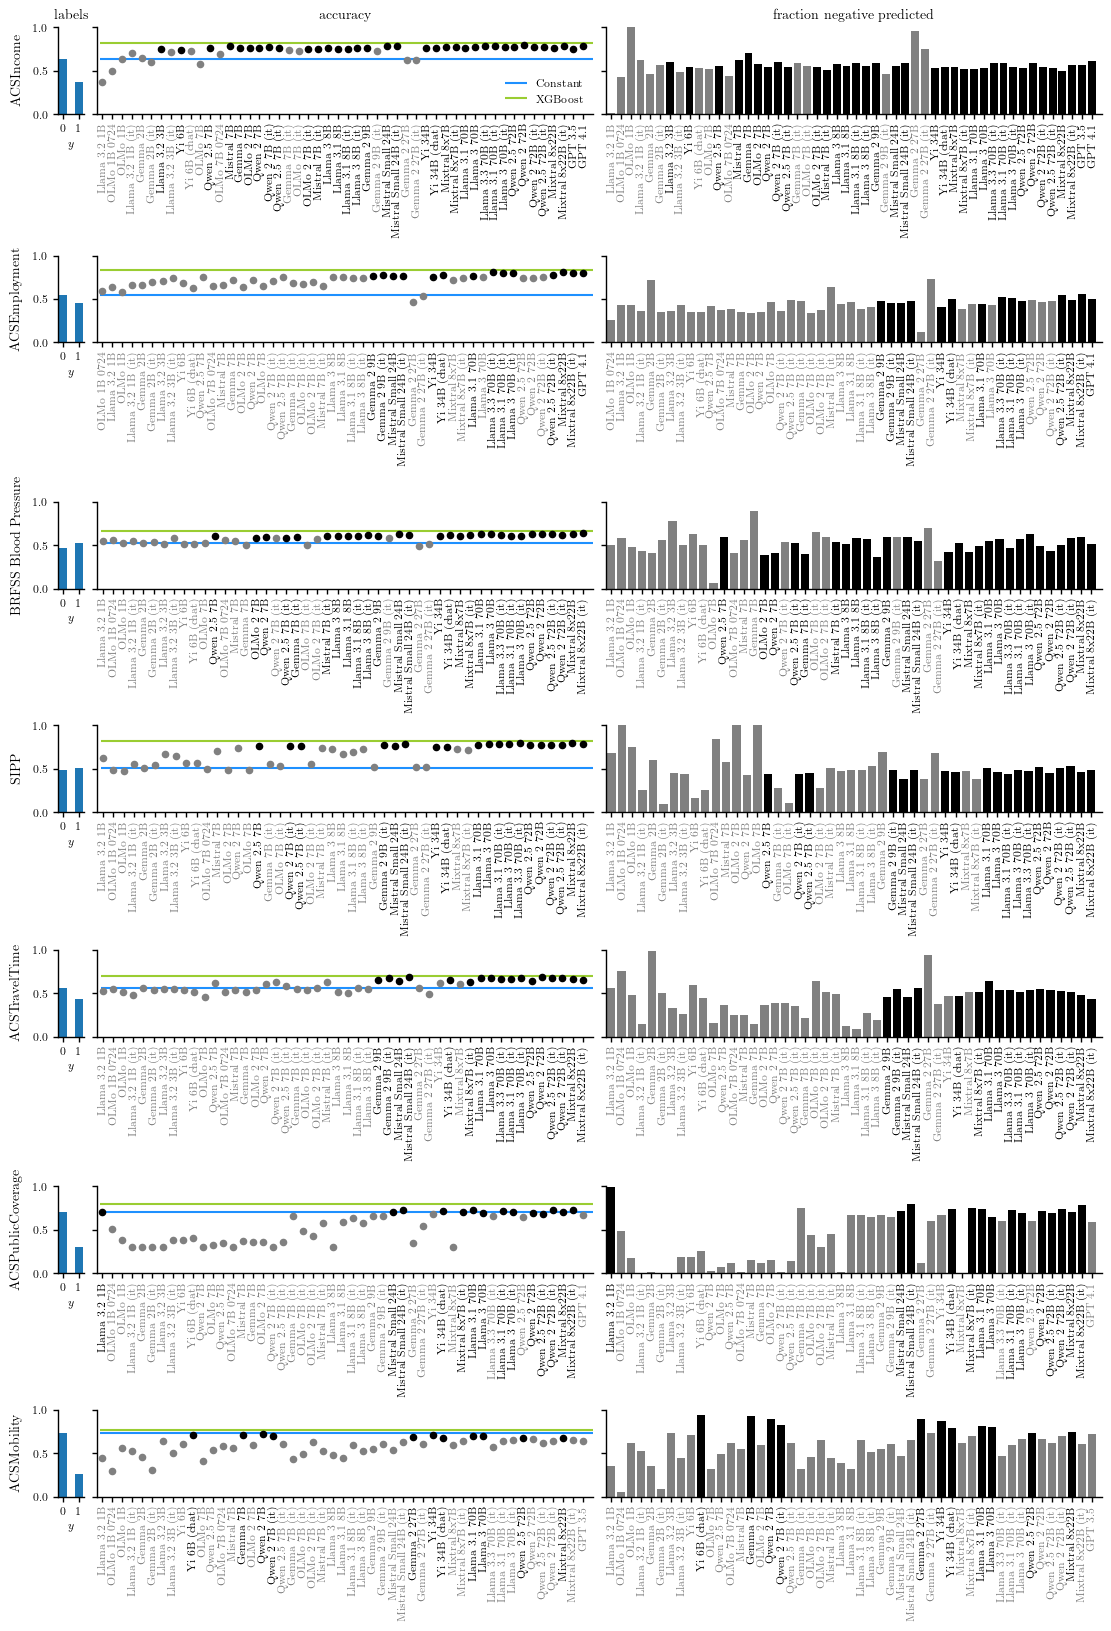

In [46]:
tasks_to_plot = TASKS #[task for task in TASKS if task != 'BRFSS_Diabetes']

fig_width = 2* plt.rcParams['figure.figsize'][0]
fig_height = 5.4*plt.rcParams['figure.figsize'][1]
# manually update some rc params
mpl.rcParams['axes.titlesize'] = 10

fig, axs = plt.subplots(
    nrows= len(tasks_to_plot),
    ncols=3,
    figsize=(fig_width, fig_height),
    constrained_layout=True,
    gridspec_kw={"width_ratios": [0.5, 9.5, 9.5]},
    sharey='row'
)


# set column titles
titles = ["labels", select_by.replace('_', ' '), 'fraction negative predicted']
for c, title in enumerate(titles):
    axs[0,c].set_title(title)

for i, task in enumerate(tasks_to_plot):
    print(task)
    ax_label, ax_accuracy, ax_frac_neg = axs[i]
    mask = (df["task"] == task) & (df["model"].isin(predictions[task].columns))

    # task as row label on the left
    ax_label.annotate(
        task.replace("_", " "),
        xy=(0, 0.5),
        xytext=(-ax_label.yaxis.labelpad, 0),
        xycoords=ax_label.yaxis.label,
        textcoords="offset points",
        size="medium",
        ha="right",
        va="center",
        rotation=90,
    )

    y_true = data[task][1]
    # define models to highlight in black
    # models_to_highlight = filter_models_better_const(df[df['task']==task], const_acc=baseline_evals[task]['Constant'][acc], acc=select_by)
    models_to_highlight = get_top_models_by_eps(df[df['task']==task], eps=eps, acc=select_by)
    plot_general_performance_task(axs[i], df=df[mask], baseline_evals=baseline_evals[task], ytrue=y_true, models_to_highlight=models_to_highlight, acc=select_by)

axs[0, 1].legend(loc='lower right')

file_name = "".join(
    [
        f"performance-{select_by.replace('_','-')}-{num_shots}-shot",
        f"_tresh_fitted-{fit_threshold_for.replace('_','-')}" if threshold_fitted == 1 else "",
        "_better_const" if restrict_to_better_const else "",
        "_pos_instances" if restrict_to_positive_label else "",
        "_neg_instances" if restrict_to_negative_label else "",
    ]
)
print(file_name)
for ending in [".svg", ".pdf"]:
    plt.savefig(FIGURES_PAPER_DIR / (file_name + ending))
plt.show()

## top-k models

In [ ]:
from mono_multi.utils import get_top_models_by_k

top_k = 10
topk_models = {}
for task in TASKS:
    mask = df['task']==task
    models = get_top_models_by_k(df[mask], k=top_k, acc=select_by)
    topk_models[task] = df[mask & (df['model'].isin(models))].sort_values(by='accuracy', ascending=False)

In [30]:
topk_models['ACSIncome']

,task,model,is_inst,threshold_fitted,threshold,threshold_obj,accuracy,balanced_accuracy,bench_hash,num_shots,...,prompt_feature_order,prompt_example_order,prompt_example_composition,eval_results_path,predictions_path,correct_order_bias,fpr,fnr,n_samples,num_pred_negatives
11,ACSIncome,meta-llama--Meta-Llama-3.3-70B-Instruct,1,1,9.994114e-01,balanced_accuracy,0.789462,0.782966,182766217,0,...,default,NaN,NaN,/Volumes/mgorecki/monoculture/results/0-bullet...,/Volumes/mgorecki/monoculture/results/0-bullet...,0,0.192450,0.241618,166450,99763
30,ACSIncome,Qwen--Qwen2.5-72B,0,1,3.485540e-01,balanced_accuracy,0.784806,0.776655,1670235270,0,...,default,NaN,NaN,/Volumes/mgorecki/monoculture/results/0-bullet...,/Volumes/mgorecki/monoculture/results/0-bullet...,0,0.192497,0.254193,166450,100528
170,ACSIncome,mistralai--Mistral-Small-24B-Instruct-2501,1,1,8.932039e-01,balanced_accuracy,0.781454,0.773966,1493987197,0,...,default,NaN,NaN,/Volumes/mgorecki/monoculture/results/0-bullet...,/Volumes/mgorecki/monoculture/results/0-bullet...,0,0.197696,0.254373,166450,99992
115,ACSIncome,gpt-4.1,0,1,2.061154e-09,balanced_accuracy,0.780622,0.783749,2081207790,0,...,default,NaN,NaN,/Volumes/mgorecki/monoculture/results/0-bullet...,/Volumes/mgorecki/monoculture/results/0-bullet...,0,0.228085,0.204416,166448,93734
181,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,7.574402e-03,balanced_accuracy,0.779946,0.777026,3002554001,0,...,default,NaN,NaN,/Volumes/mgorecki/monoculture/results/0-bullet...,/Volumes/mgorecki/monoculture/results/0-bullet...,0,0.211924,0.234024,166450,97249
142,ACSIncome,meta-llama--Meta-Llama-3.1-70B-Instruct,1,1,8.811831e-01,balanced_accuracy,0.776461,0.774748,936847428,0,...,default,NaN,NaN,/Volumes/mgorecki/monoculture/results/0-bullet...,/Volumes/mgorecki/monoculture/results/0-bullet...,0,0.218767,0.231738,166450,96389
35,ACSIncome,meta-llama--Meta-Llama-3-70B-Instruct,1,1,9.740603e-01,balanced_accuracy,0.771505,0.780064,2250115911,0,...,default,NaN,NaN,/Volumes/mgorecki/monoculture/results/0-bullet...,/Volumes/mgorecki/monoculture/results/0-bullet...,0,0.252326,0.187546,166450,90152
44,ACSIncome,Qwen--Qwen2.5-7B-Instruct,1,1,1.826227e-01,balanced_accuracy,0.767107,0.752333,2007864665,0,...,default,NaN,NaN,/Volumes/mgorecki/monoculture/results/0-bullet...,/Volumes/mgorecki/monoculture/results/0-bullet...,0,0.191756,0.303578,166450,103630
124,ACSIncome,mistralai--Mixtral-8x7B-Instruct-v0.1,1,1,6.007443e-02,balanced_accuracy,0.766260,0.775137,4271623370,0,...,default,NaN,NaN,/Volumes/mgorecki/monoculture/results/0-bullet...,/Volumes/mgorecki/monoculture/results/0-bullet...,0,0.258456,0.191269,166450,89735
113,ACSIncome,mistralai--Mistral-Small-24B-Base-2501,0,1,5.461255e-01,balanced_accuracy,0.765978,0.767046,2002779533,0,...,default,NaN,NaN,/Volumes/mgorecki/monoculture/results/0-bullet...,/Volumes/mgorecki/monoculture/results/0-bullet...,0,0.236996,0.228913,166450,94298


## Plot Risk Scores

In [31]:
risk_scores = load_model_outputs_same_prompt(
    df, tasks=TASKS, return_risk_scores=True
)

ACSIncome
ACSEmployment
BRFSS_Blood_Pressure
SIPP
ACSTravelTime
ACSPublicCoverage
ACSMobility


In [32]:
models_common = set(risk_scores[TASKS[0]].columns)
for task in TASKS[1:]:
    models_common = models_common.intersection(set(risk_scores[task].columns))

ACSIncome


/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_169/4128168326.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[-1, -1].legend()


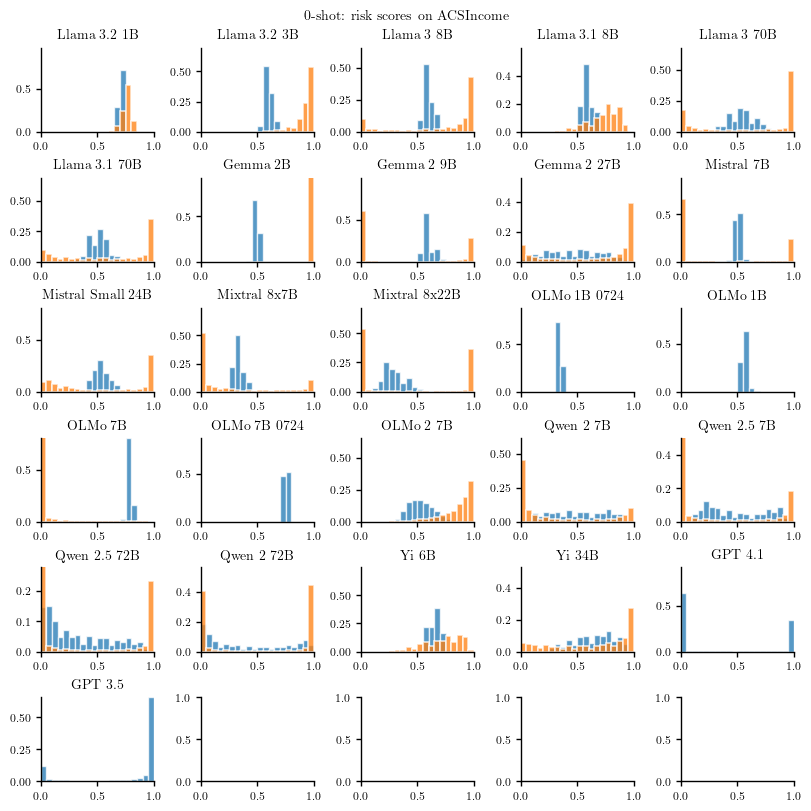

ACSEmployment


/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_169/4128168326.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[-1, -1].legend()


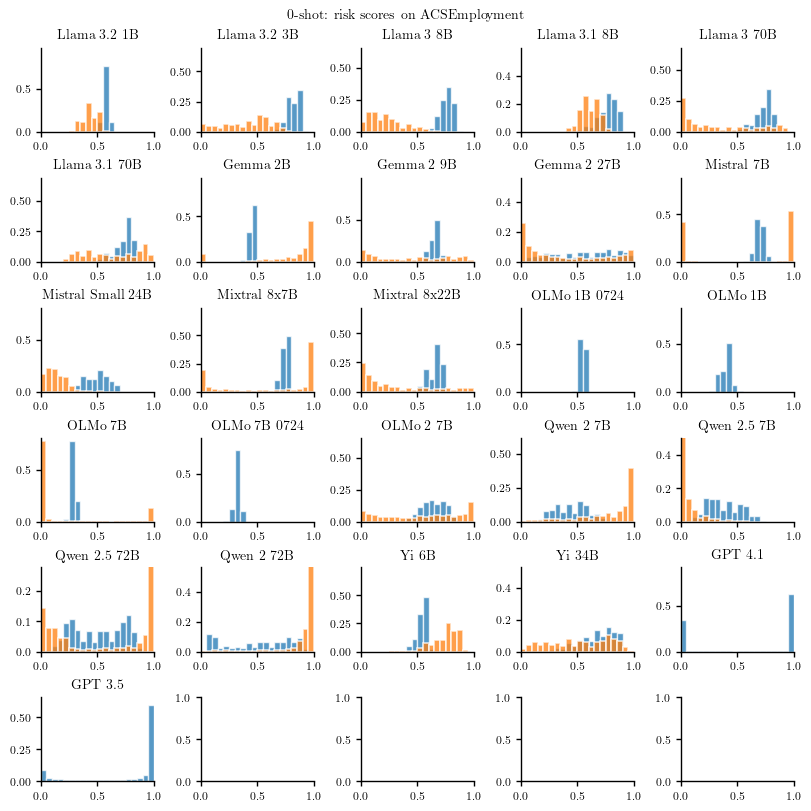

BRFSS_Blood_Pressure


/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_169/4128168326.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[-1, -1].legend()


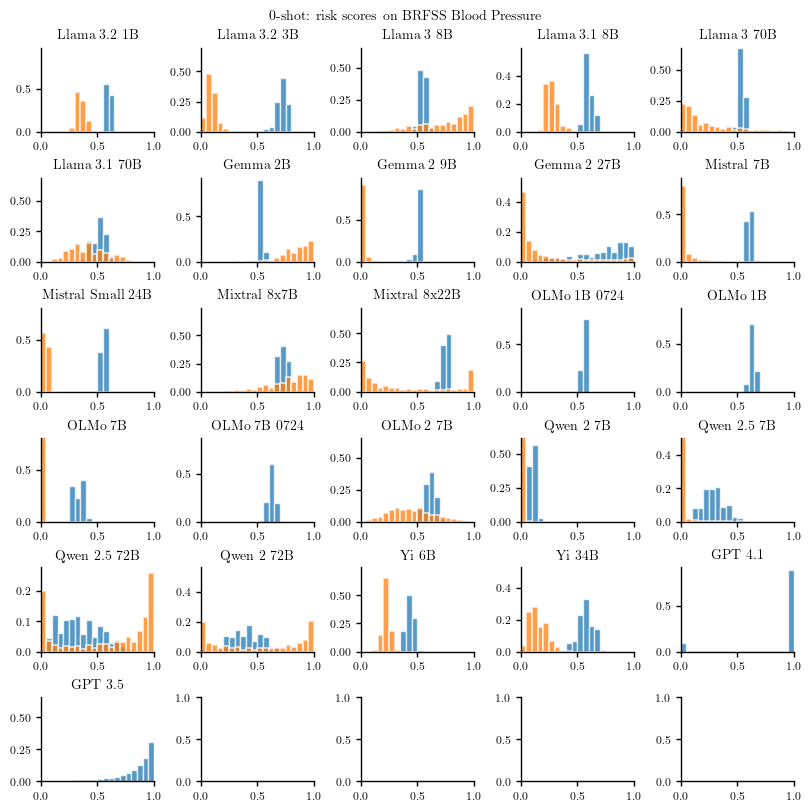

SIPP


/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_169/4128168326.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[-1, -1].legend()


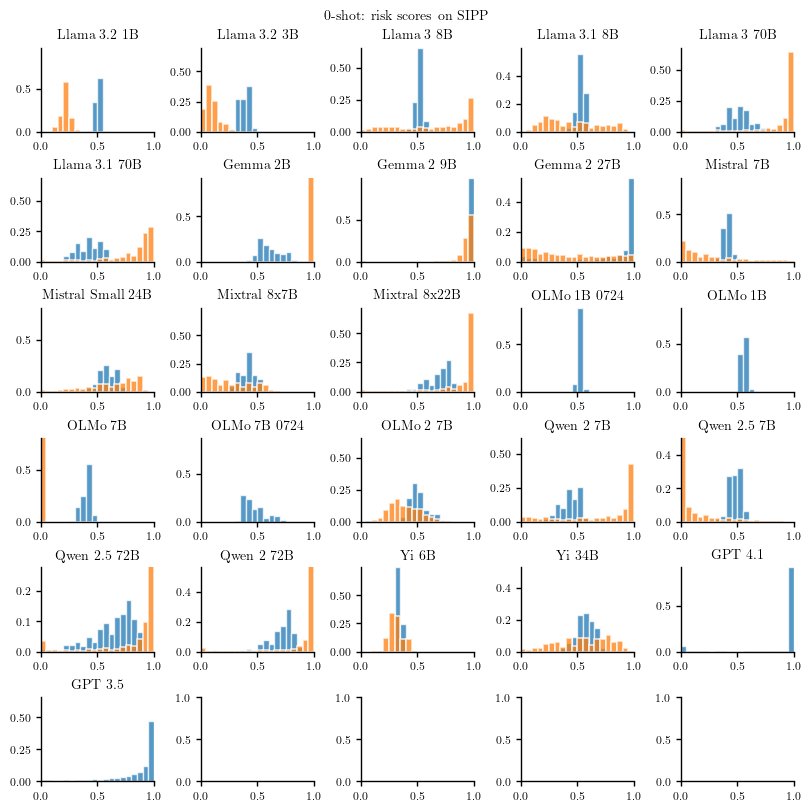

ACSTravelTime


/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_169/4128168326.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[-1, -1].legend()


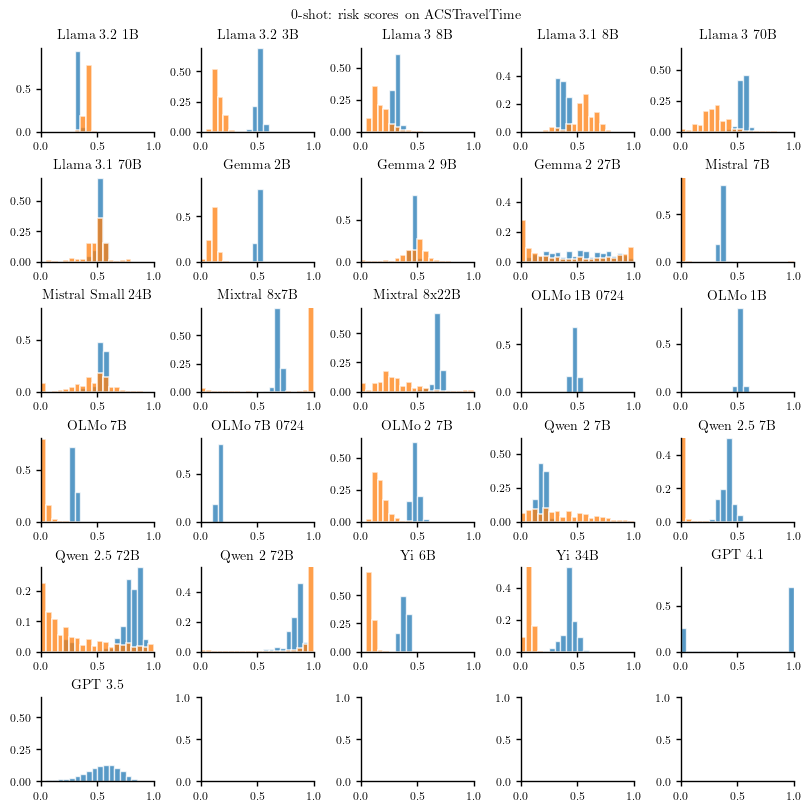

ACSPublicCoverage


/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_169/4128168326.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[-1, -1].legend()


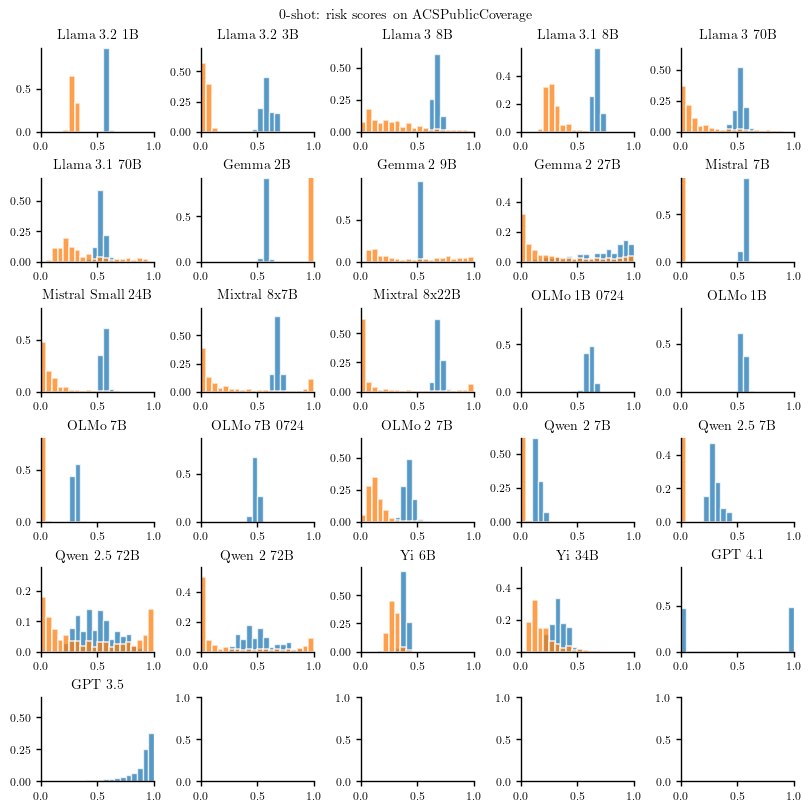

ACSMobility


/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_169/4128168326.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[-1, -1].legend()


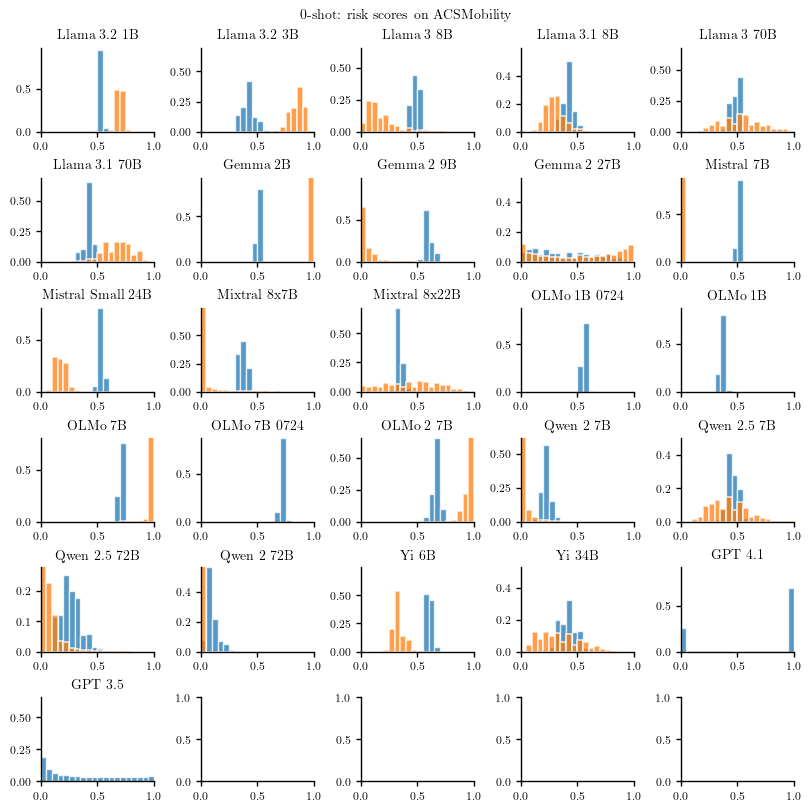

In [33]:
base_models = sort_by_size_and_family(
    [model for model in models_common if not is_instruction_tuned(model)]
)
it_models = sort_by_size_and_family(
    [model for model in models_common if is_instruction_tuned(model)])
len(base_models), len(it_models)

# to ensure axis are the same across plots, get max y value per model
ymax = {}
for model in base_models:
    ymax[model] = 0
    for task in TASKS:
        N = risk_scores[task].shape[0]
        task_max = max(
            np.histogram(
                risk_scores[task][model],
                weights=np.zeros((N,)) + 1.0 / N,
                bins=np.arange(0, 1.01, 0.05),
            )[0]
        )
        if task_max > ymax[model]:
            ymax[model] = task_max


for task in TASKS:
    print(task)
    N = risk_scores[task].shape[0]
    num_row, num_col = 6, 5
    fig, axs = plt.subplots(num_row, num_col, figsize=(8, 8), constrained_layout=True)
    fig.suptitle(f"{num_shots}-shot: risk scores on {task.replace('_', ' ')}")
    for i, model in enumerate(base_models):

        coresponding_it_model = [
            itm
            for itm in it_models
            if prettify_model_name(key_to_model(itm)).startswith(
                prettify_model_name(key_to_model(model))
            )
        ]
        # print(model, coresponding_it_model)

        axs[i // num_col, i % num_col].set_xlim(0.0, 1.0)
        axs[i // num_col, i % num_col].set_title(
            prettify_model_name(key_to_model(model))
        )
        ys, xs, _ = axs[i // num_col, i % num_col].hist(
            risk_scores[task][model],
            weights=np.zeros((N,)) + 1.0 / N,
            alpha=0.75,
            label="base",
            bins=np.arange(0, 1.01, 0.05),
            edgecolor="w",
            linewidth=1,
        )
        axs[i // num_col, i % num_col].set_ylim(0.0, ymax[model])
        if len(coresponding_it_model) == 1:
            axs[i // num_col, i % num_col].hist(
                risk_scores[task][coresponding_it_model[0]],
                weights=np.zeros((N,)) + 1.0 / N,
                alpha=0.75,
                label="it",
                bins=np.arange(0, 1.01, 0.05),
                edgecolor="w",
                linewidth=1.2,
            )
    axs[-1, -1].legend()

    file_name = "".join(
        [
            f"risk-scores-{num_shots}-shot",
            f"-{task}",
            "_tresh_fitted" if threshold_fitted == 1 else "",
            "_better_const" if restrict_to_better_const else "",
            "_pos_instances" if restrict_to_positive_label else "",
            "_neg_instances" if restrict_to_negative_label else "",
            ".png",
        ]
    )
    plt.show()